# Multi-Object Segmentation

In object segmentation tasks, we aim to find the boundaries of target objects in images. There are many applications for segmenting objects in images, such as self-driving cars and medical imaging analysis. In Chapter 6, Single-Object Segmentation, we learned how to build a single-object segmentation model using PyTorch. In this chapter, we will focus on developing a deep learning model using PyTorch to perform multi-object segmentation. **In multi-object segmentation, we are interested in automatically outlining the boundaries of multiple target objects in an image**.

The **boundaries of objects in an image are usually defined by a segmentation mask that's the same size as the image**. In the segmentation mask, **all the pixels that belong to a target object are labeled the same based on a pre-defined labeling**. For instance, in the following screenshot, you can see **a sample image with two types of target**: **babies** and **chairs**. The corresponding segmentation mask is shown in the middle of the screenshot. As we can see, the pixels belonging to the babies and chairs are labeled differently and colored in yellow and green, respectively.

![](segmentation_exemple.png)

The **goal of multi-object segmentation is to predict a segmentation mask when given an image so that each pixel in the image is labeled based on its object class**. In this chapter, we will learn how to develop an algorithm to automatically segment $20$ target objects in the **Visual Object Classes (VOC)** dataset.

## **Creating custom datasets**

We will be using the VOC segmentation data from the torchvision.datasets package. This dataset consists of outlined images with $20$ object classes. Together with the background, this comes to $21$ object classes, which were labeled from $0$ to $20$:

* background: 0
* airplane: 1
* bicycle: 2
* bird: 3
* boat: 4
* bottle: 5
* bus: 6
* car: 7
* cat: 8
* chair: 9
* cow: 10
* dining table: 11
* dog: 12
* horse: 13
* motorbike: 14
* person: 15
* potted plant: 16
* sheep: 17
* sofa: 18
* train: 19
* tv/monitor : 20

> To learn more about the VOC dataset, visit the following link: http://host.robots.ox.ac.uk/pascal/VOC/voc2012/index.html.

In this recipe, we will learn **how to load the `VOCSegmentation` data using the `torchvision` package and create custom dataset classes that will be used to train and validate the model**.

### **How to do it**

In [1]:
# 1 Import the required packages: 
from torchvision.datasets import VOCSegmentation
from torchvision.transforms.functional import to_tensor, to_pil_image
from PIL import Image
import numpy as np
import torch

# 2 Define a custom dataset class by subclassing the VOCSegmentation class:
class myVOCSegmentation(VOCSegmentation):
    def __getitem__(self, index):
        img = Image.open(self.images[index]).convert('RGB')
        target = Image.open(self.masks[index])
        if self.transforms is not None:
            augmented = self.transforms(image=np.array(img), mask=np.array(target))
            img = augmented['image']
            target = augmented['mask'] 
            target[target>20]=0
        img = to_tensor(img) 
        target = torch.from_numpy(target).type(torch.long)
        return img, target
    
# 3 Define transformation functions:
from albumentations import (
    HorizontalFlip,
    Compose,
    Resize,
    Normalize
)

mean = [0.485, 0.456, 0.406] 
std = [0.229, 0.224, 0.225]
h, w = 520, 520

transform_train = Compose([Resize(h, w), HorizontalFlip(p=0.5), Normalize(mean=mean, std=std)])
transform_val = Compose([Resize(h, w), Normalize(mean=mean, std=std)])


In [2]:
# 4 Define an object of the myVOCSegmentation class for training:
path2data = "../data/voc/"    
train_ds = myVOCSegmentation(path2data, year='2012', image_set='train', download=False, transforms=transform_train)       
print(len(train_ds))

1464


In [3]:
# Define an object of the myVOCSegmentation class for validation:
val_ds = myVOCSegmentation(path2data, year='2012', image_set='val', download=False, transforms=transform_val)
print(len(val_ds))

1449


In [4]:
# 5 Let's show a sample image and its segmentation mask from the training data.
from skimage.segmentation import mark_boundaries
import matplotlib.pylab as plt
%matplotlib inline
np.random.seed(0)
num_classes=21
COLORS = np.random.randint(0, 2, size=(num_classes+1, 3), dtype="uint8")

# Define the show_img_target helper function:
def show_img_target(img, target):
    if torch.is_tensor(img):
        img = to_pil_image(img)
        target = target.numpy()
    for ll in range(num_classes):
        mask = (target==ll)
        img = mark_boundaries(np.array(img), mask, outline_color=COLORS[ll], color=COLORS[ll])
    plt.imshow(img)

# Define the re_normalize helper function:
def re_normalize (x, mean=mean, std= std):
    x_r = x.clone()
    for c, (mean_c, std_c) in enumerate(zip(mean, std)):
        x_r[c] *= std_c
        x_r[c] += mean_c
    return x_r

# Get a sample image and its segmentation mask from train_ds:
img, mask = train_ds[6]
print(img.shape, img.type(),torch.max(img))
print(mask.shape, mask.type(),torch.max(mask))

torch.Size([3, 520, 520]) torch.FloatTensor tensor(2.6400)
torch.Size([520, 520]) torch.LongTensor tensor(4)


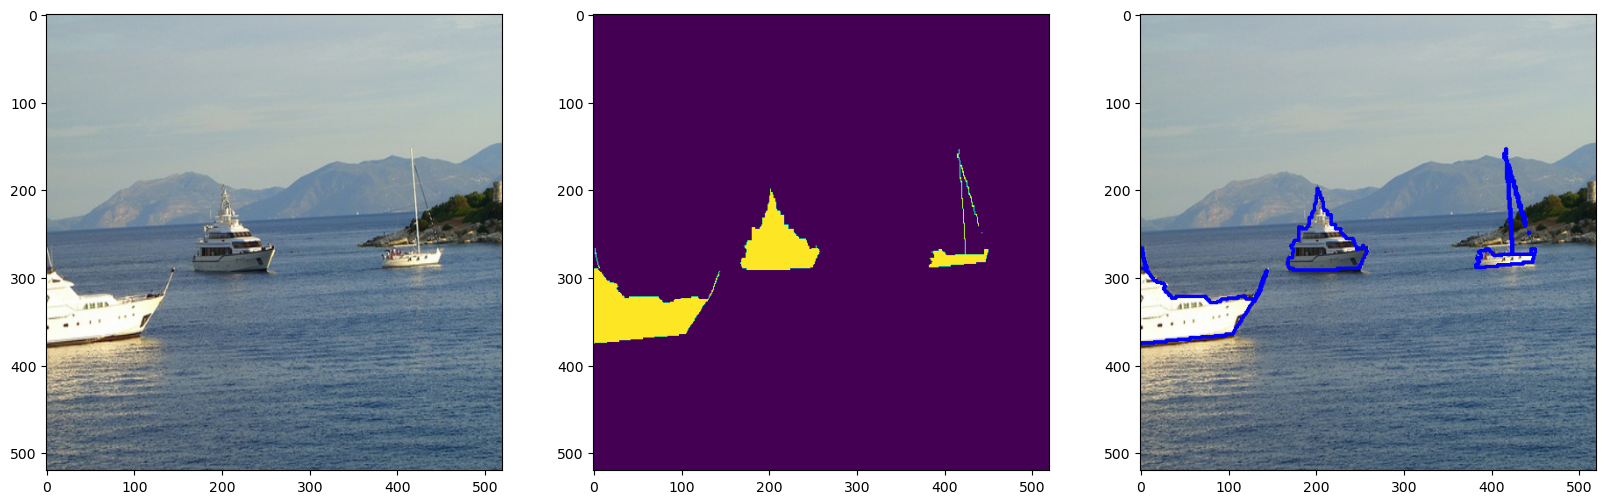

In [5]:
# Display the sample image with its segmentation mask and contours:

plt.figure(figsize=(20, 20))
img_r = re_normalize(img)
plt.subplot(1, 3, 1) 
plt.imshow(to_pil_image(img_r))
plt.subplot(1, 3, 2) 
plt.imshow(mask)
plt.subplot(1, 3, 3) 
show_img_target(img_r, mask)

In [6]:
# 6 Similarly, get a sample image with its segmentation mask from val_ds:
img, mask = val_ds[0]
print(img.shape, img.type(),torch.max(img))
print(mask.shape, mask.type(),torch.max(mask))

torch.Size([3, 520, 520]) torch.FloatTensor tensor(2.6226)
torch.Size([520, 520]) torch.LongTensor tensor(1)


<Figure size 2000x2000 with 0 Axes>

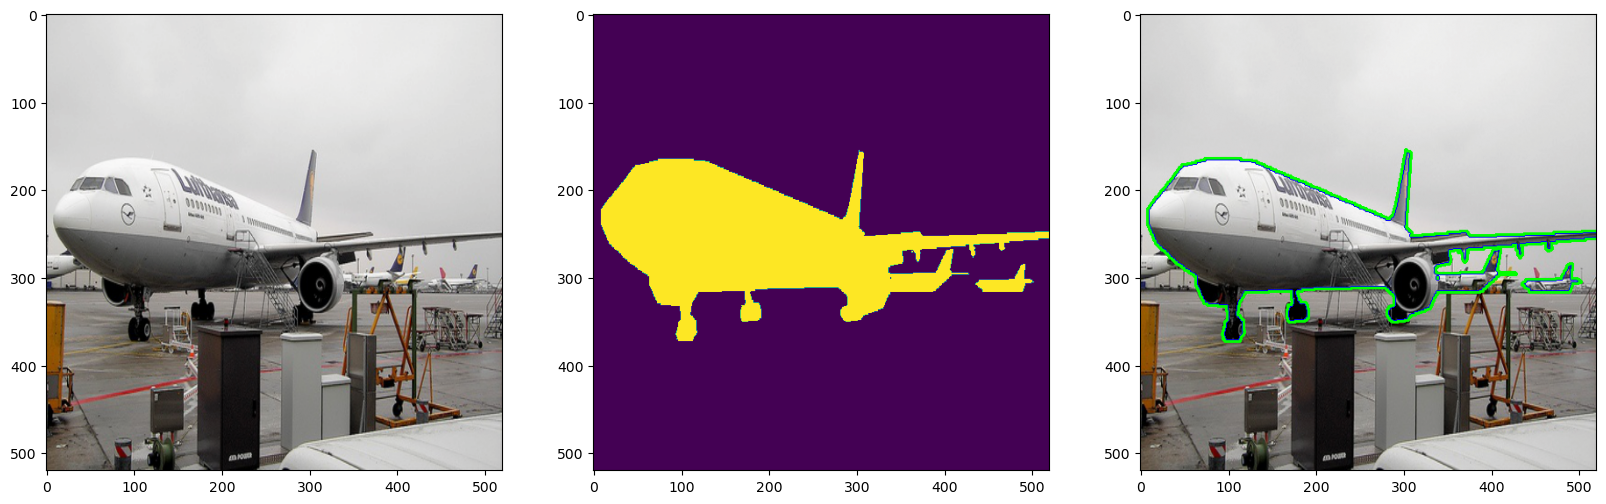

In [7]:
# Display the sample image with its segmentation mask and contours:

plt.figure(figsize=(20, 20))
plt.figure(figsize=(20, 20))

img_r = re_normalize(img)
plt.subplot(1, 3, 1) 
plt.imshow(to_pil_image(img_r))

plt.subplot(1, 3, 2) 
plt.imshow(mask)

plt.subplot(1, 3, 3) 
show_img_target(img_r, mask)

In [8]:
# 7 Define data loaders:
from torch.utils.data import DataLoader
train_dl = DataLoader(train_ds, batch_size=4, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=8, shuffle=False)

# 8 Get a sample data batch from train_dl:
for img_b, mask_b in train_dl:
    print(img_b.shape, img_b.dtype)
    print(mask_b.shape, mask_b.dtype)
    break

torch.Size([2, 3, 520, 520]) torch.float32
torch.Size([2, 520, 520]) torch.int64


In [9]:
# 8 Get a sample data batch from val_dl:

for img_b, mask_b in val_dl:
    print(img_b.shape, img_b.dtype)
    print(mask_b.shape, mask_b.dtype)
    break

torch.Size([4, 3, 520, 520]) torch.float32
torch.Size([4, 520, 520]) torch.int64


### **How it works**

In step 1, we imported the required packages. We imported `VOCSegmentation` from the `torchvision.datasets` package so that we can load the **VOC dataset**. We also imported the `to_tensor` and `to_pil_image` methods from `torchvision.transforms.functional` to**convert PIL images into PyTorch tensors and vice versa**.

In step 2, we defined a custom dataset class by subclassing the `VOCSegmentation` class. The reason for subclassing is that **we needed to make a modification to the `__getitem__` method of the `VOCSegmentation` class**. In the method, **we loaded the image and target as PIL objects from their files. Then, we applied transformations on the image and target**.

> Note that the pixel values in the target should be in the range of $[0, 20]$ since there are $21$ object classes in the VOC dataset. As such, we set any possible value greater than $20$ to $0$ so that it's counted as a background pixel: `target[target > 20] = 0`.

In step 3, we defined the transformation function using the `albumentations` package. We learned how to install and use this package in Chapter 6, *Single-Object Segmentation*. For the training data, three transformations called `Resize`, `HorizontalFlip`, and `Normalize` were applied. For the validation data, two transformations were applied: Resize and `Normalize`. We used Resize to resize all the images so that they were the same size. We used `HorizontalFlip` to augment the training data by flipping the images horizontally. Finally, we used `Normalize` to `normalize` the images.

In step 4, we defined two objects of the `myVOCSegmentation` class for the training and validation datasets. The arguments for this class are as follows:

* `path2data`: A string. The path to store/load the VOC dataset after downloading it
* `year`: The dataset year. A `'2012'` or `'2007'` string
* `image_set`: Set to `'train'` for training and `'val'` for validation
* `download`: Set to `True` to download the data from the internet for the first time
* `transforms`: Augmentation functions

As we saw, there were $1446$ and $1449$ items in `train_ds` and `val_ds`, respectively.

In step 5, we got a sample image and its target mask from `train_ds`. Then, we printed the shape of the tensor and displayed the image and mask. Note that the returned image is a tensor of the `torch.FloatTensor` type with a maximum pixel value of $2.64$.

> **The `to_tensor` method converts a `PIL` image into a PyTorch tensor with pixel values in the range of $[0, 1]$**. However, **due to the normalization function, the maximum pixel values will exceed $1$**.

Also, the returned mask was a tensor of the `torch.LongTensor` type with a maximum value of $4$.

> The image contains boats, which were assigned label $4$ in the VOC dataset.

To display the image, **we renormalize the image using the `re_normalize` helper function**. The inputs to the function are as follows:

* `x`: A normalized tensor of shape `[3, Height, Width]`.
* `mean`: A tuple/list of three values. The default value is `[0.485, 0.456, 0.406]`.
* `std`: A tuple/list of three values. The default value is `[0.229, 0.224, 0.225]`.
As you may recall, images are normalized in `myVOCSegmentation` using the normalize transformation function. Using the `re_normalize` helper function, we get the original pixel values of the image for display purposes only. 

To display the image and its target mask, we defined a helper function called `show_img_target`. The helper function's inputs are as follows:

* `img`: A PIL image or PyTorch tensor
* `target`: A NumPy array or PyTorch tensor

In this function, we used the `mark_boundaries` function from the `skimage.segmentation` package to overlay a mask on the image. Note that, if you rerun this part of the code, the image and its mask will be flipped due to the `HorizontalFlip` transformation.

In step 6, we got a sample image and its target mask from `val_ds`, printed their shape, and displayed them. As you saw, the returned mask was a tensor of integer values with a maximum value of $1$. 

> The image contains an airplane, which was assigned label 1 in the VOC dataset.

In step 7, we defined the `train_dl` and `val_dl` data loaders for the training and validation datasets, respectively.

In step 8, we extracted data batches from `train_dl` and `val_dl`, respectively. Note that the shapes of the returned tensors are `(batch_size, 3, height, width)` and `(batch_size, height, width)`, respectively.

## **Defining and deploying a model**

In this recipe, we will learn how to create and deploy a semantic segmentation model using the `torchvision.models` package. The model is called `DeepLabV3Net101` and is based on the article ***Rethinking Atrous Convolution for Semantic Image Segmentation*** available [here](https://arxiv.org/abs/1706.05587).

This article emphasizes the use of atrous convolutions to overcome the limitations of regular convolutional neural networks and pooling layers in semantic segmentation.

The model was pre-trained on a subset of the **COCO train2017** dataset. When we import the model, we have the option to load pre-trained weights or use random weights.

The model expects input images to be scaled to the range of `[0, 1]` and then normalized by subtracting `mean=[ 0.485, 0.456, 0.406]` and dividing by `std=[0.229, 0.224, 0.225]`. Also, the model was trained on images that were resized to $520 \times 520$. As you may recall from the Creating custom datasets recipe, we applied all these transformations to the inputs in the `myVOCSegmentation` class. Therefore, once a data batch has been fetched from the data loader, it is ready for the model.

Since the model was pre-trained using the **COCO train2017** dataset, we can deploy the model right away on the VOC dataset. However, to get better performance, we can also train the model on the VOC train dataset before deploying it. We will learn how to train the model in the Training the model recipe.

In this recipe, we will show you how to load the model with pre-trained weights and then deploy it on the VOC validation dataset.

### **How to do it**

In [10]:
# 1 Import the required packages:
import torch
from torchvision.models.segmentation import deeplabv3_resnet101
# 2 Define an object of the segmentation class:
model = deeplabv3_resnet101(pretrained=True, num_classes=21)
# 3 Move the model to the CUDA device:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
# 4 Print the model:
print(model)

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [11]:
# 5 Deploy the model on a data batch from the validation dataset:
from torch import nn
model.eval()
with torch.no_grad():
    for xb, yb in val_dl:
        yb_pred = model(xb.to(device))
        yb_pred = yb_pred["out"].cpu()
        print(yb_pred.shape)
        yb_pred = torch.argmax(yb_pred, axis=1)
        break
print(yb_pred.shape)

torch.Size([4, 21, 520, 520])
torch.Size([4, 520, 520])


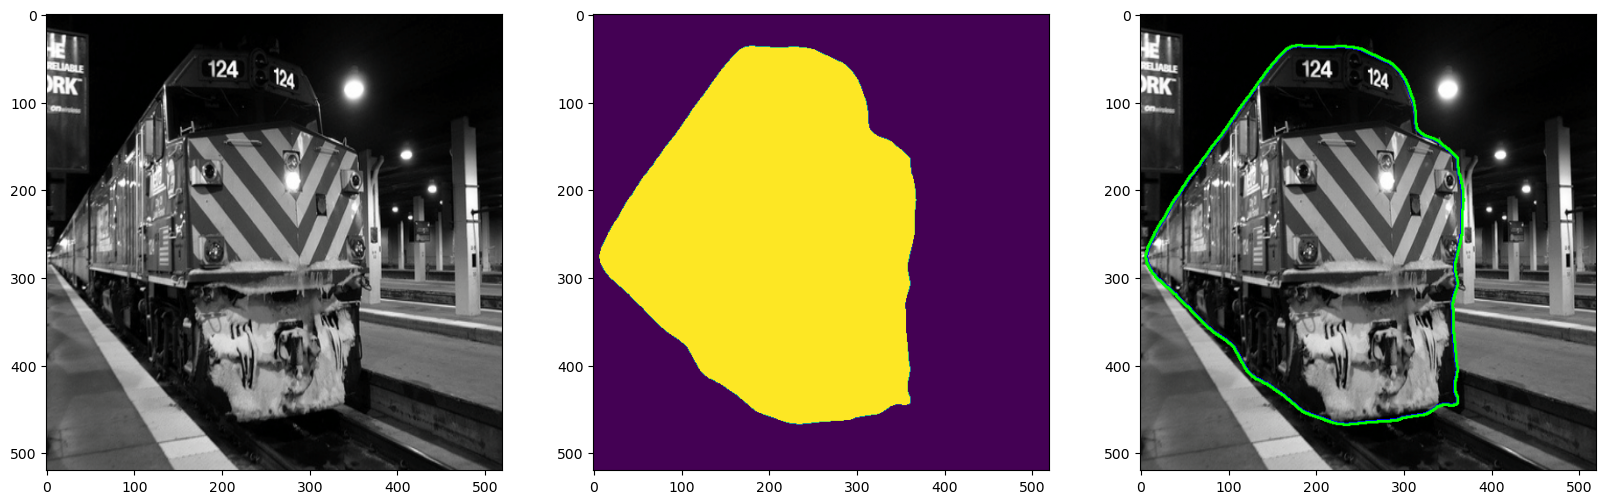

In [16]:
# 6 Display a sample image and the corresponding predictions:
plt.figure(figsize=(20, 20))

n = 3
img, mask = xb[n], yb_pred[n]
img_r = re_normalize(img)
plt.subplot(1, 3, 1) 
plt.imshow(to_pil_image(img_r))
plt.subplot(1, 3, 2) 
plt.imshow(mask)
plt.subplot(1, 3, 3) 
show_img_target(img_r, mask)

### **How it works**

In step 1, we imported the required packages. The `deeplabv3_resnet101` class is implemented in `torchvision` models.

In step 2, we created an object of the `deeplabv3_resnet101` class. The important inputs to the class are as follows:
* `pretrained`: If set to `True`, pre-trained weights are automatically downloaded
* `num_classes`: The number of object classes. The default value is set to $21$ for the VOC dataset.

In step 3, we defined a CUDA device, if available, and then moved the model to the CUDA device.

In step 4, we printed the model. The model is huge, so only a snippet of the model was shown. You should see the entire model on the screen when executing the `print` command on your computer.

In step 5, we deployed the model on the VOC validation dataset. As we mentioned previously, since the model was pre-trained on a subset of the COCO 2017 dataset, it should perform well on the VOC dataset. First, we set the model in the evaluation model. This is necessary since certain layers, such as the dropout and normalization layers, perform differently in the training and evaluation stages.

> Before deploying the model, use the `.eval()` method to set the model in the evaluation model.

Next, we fetched a data batch from the `val_dl` data loader and fed it to the model. The good news is that no pre-processing is required.

> To deploy the model on an individual image outside the VOC dataset or images streaming from a camera, make sure to pre-process the image before feeding it to the model.

As we saw, the model output shape is `[batch_size, num_classes, height, width]`. In other words, the model produces $21$ probability masks corresponding to $21$ object classes. The first mask at index zero corresponds to the background, while the remaining masks correspond to $20$ objects. Then, for each pixel, the class with the highest probability among the $21$ masks was assigned to the pixel using the `argmax()` method.

In step 6, we displayed a sample image from the extracted data batch, the predicted segmentation mask, and the overlay contours. As we saw, the pre-trained model did a very good job of outlining the objects. You can try displaying other images and predictions by changing the image index, $n$.

### **See also**

You can find other segmentation models, such as `fcn_resnet50` in the `torchvision` package. Try them out and see how they perform for this task. 

## **Defining the loss function and optimizer**

**The classical criterion for multi-object segmentation is the cross-entropy (CE) loss function**. The **CE loss compares each pixel of the predictions with that of the ground truth**. We will use the `CrossEntropyLoss` class from the `torch.nn` package in this recipe.

For the optimization, we will use the Adam optimizer from the `torch.optim` package with a small learning rate since the model was pre-trained. If you want to train the model from scratch using random weights, try using a higher learning rate, such as `3E-4`. The learning rate is a hyperparameter. Typically, you will need to try a few different values before finalizing its value for the best performance.

In this recipe, you will learn how to define a loss function, optimizer, and learning rate schedule for multi-object segmentation.

### **How to do it**

In [17]:
# 1 Define the criterion:
from torch import nn
criterion = nn.CrossEntropyLoss(reduction="sum")

# 2 Define the optimizer:
from torch import optim
opt = optim.Adam(model.parameters(), lr=1e-6)

# 3 Define a helper function to calculate the loss per data batch:
def loss_batch(loss_func, output, target, opt=None):   
    loss = loss_func(output, target)
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()
    return loss.item(), None

# 4 Define the learning rate schedule:
from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

# 5 Define a helper function to get the learning rate:
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']
current_lr = get_lr(opt)

print('current lr={}'.format(current_lr))

current lr=1e-06


### **How it works**

In step 1, we defined the criterion. We used the `CrossEntropyLoss` class from the `torch.nn` package to do so. This criterion combines `nn.LogSoftmax()` and `nn.NLLLoss()` into a single class.

For numerical stability reasons, PyTorch integrates the `softmax` function into the `CrossEntropyLoss` loss instead of directly applying it to the model output.
Note that we set `reduction="sum"` since we want to return the sum of the loss values per data batch.

In step 2, we defined the optimizer. We used the `Adam` optimizer from the `torch.optim` package with a small learning rate since the model was pre-trained. If you want to train the model from scratch using random weights, try using a higher learning rate, such as `3E-4`.

In step 3, we defined the `loss_batch` helper function. The inputs to the helper function are as follows:

* `loss_func`: The criterion that was defined in step 2
* `output`: A tensor of shape `(batch_size, num_classes, height, width)` containing predictions
* `target`: A tensor of shape `(batch_size, height, width)` containing the ground truth or targets
* `opt`: An object of the optimizer
In this function, we calculated the loss values per data batch. During training, the optimizer object is passed to the helper function and, as a result, the model parameters are updated using `opt.step()`. 

In step 4, we defined the learning rate schedule to automatically reduce the learning rate during training in the event of a plateau.

In step 5, we defined a helper function to read the current learning rate. This will be useful for monitoring the learning rate during training. 

## **Trainind the model**

So far, we've learned how to create training and validation datasets, build a model, and define a loss function and optimizer. We also deployed the model since it was pre-trained on a large dataset called COCO 2017. Sometimes, we will want to train the model on other datasets to get better performance. In such cases, the best method is to train the model with a small learning rate on the new dataset. This method is usually called fine-tuning the model.

Training is an iterative process. In each iteration, we select a data batch from the training dataset. Then, we feed the data to the model to get the model output. After that, we calculate the loss value. Next, we compute the gradients of the loss function with respect to the model parameters (also known as the weights). Finally, the optimizer updates the parameters based on the gradients. This loop continues. We also use the validation dataset to monitor the model's performance during training. We stop the training process when the performance plateaus. 

In this recipe, you will learn how to train the model on the VOC dataset for a multi-object segmentation task.

### **How to do it**

In [18]:
# 1 Define the loss_epoch helper function:
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    len_data = len(dataset_dl.dataset)
    for xb, yb in dataset_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)["out"]
        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)
        running_loss += loss_b
        if sanity_check is True:
            break
    loss = running_loss/float(len_data)
    return loss, None

# 2 Define the train_val helper function:
import copy

def train_val(model, params):
    num_epochs = params["num_epochs"]
    loss_func = params["loss_func"]
    opt = params["optimizer"]
    train_dl = params["train_dl"]
    val_dl = params["val_dl"]
    sanity_check = params["sanity_check"]
    lr_scheduler = params["lr_scheduler"]
    path2weights = params["path2weights"]
    loss_history = {
        "train": [],
        "val": []
    }
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))   

        model.train()
        train_loss, _ = loss_epoch(model, loss_func, train_dl, sanity_check,opt)
        loss_history["train"].append(train_loss)
        
        model.eval()
        with torch.no_grad():
            val_loss, _ = loss_epoch(model, loss_func, val_dl, sanity_check)
        loss_history["val"].append(val_loss)
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights!")
            
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print("Loading best model weights!")
            model.load_state_dict(best_model_wts)
        print("train loss: %.6f" %(train_loss))
        print("val loss: %.6f" %(val_loss))
        print("-"*10) 
    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history

In [19]:
# 3 Let's call the train_val function to train the model:
import os
path2models= "../models/"
if not os.path.exists(path2models):
        os.mkdir(path2models)
params_train = {
    "num_epochs": 100,
    "optimizer": opt,
    "loss_func": criterion,
    "train_dl": train_dl,
    "val_dl": val_dl,
    "sanity_check": False,
    "lr_scheduler": lr_scheduler,
    "path2weights": path2models + "voc_weights.pt",
}

model, loss_hist, _ = train_val(model, params_train)

Epoch 0/99, current lr=1e-06


RuntimeError: CUDA out of memory. Tried to allocate 34.00 MiB (GPU 0; 3.00 GiB total capacity; 2.57 GiB already allocated; 0 bytes free; 2.61 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
# 4 After training is complete, we can plot the progress of the training and validation losses:
num_epochs = params_train["num_epochs"]

plt.title("Train-Val Loss")
plt.plot(range(1, num_epochs+1), loss_hist["train"], label="train")
plt.plot(range(1, num_epochs+1), loss_hist["val"], label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

### **How it works**

In step 1, we defined the loss_epoch helper function.

The function inputs are as follows:

* `model`: An object of the model 
* `loss_func`: An object of the loss function
* `dataset_dl`: An object of the data loader
* `sanity_check`: A Boolean flag where the default value is False
* `opt`: An object of the optimizer

In this function, we extracted data batches from the data loader as `xb` and `yb` tensors. Next, we obtained the model output and calculated the loss value per data batch. We repeated this process for the entire dataset and returned the average loss value per epoch.

In step 2, we defined the `train_val` helper function. The function inputs are as follows:

* `model`: An object of the mode
* `params`: A Python dictionary containing the training parameters

In this function, we trained the model for `num_epochs` iterations. In each iteration, we set the model in train mode and trained the model for an epoch. Then, we evaluated the model on the validation dataset. We stored the model parameters if the validation results improved in each iteration. Also, we used the learning rate schedule to reduce the learning rate if the validation performance reached a plateau. The function returns the trained model and a dictionary containing the loss values for each iteration.

In step 3, we set the training parameters in `params_train` and called the `train_val` function to train the model. You can set the `sanity_check` flag to `True` to quickly execute a few iterations of the training loop and fix any possible errors. You can also change `num_epochs`, depending on the training progress. Typically, if training plateaus quickly, a small value for `num_epochs` is enough since you will not get any improvements by doing any extra training.

In step 4, we plotted the results of the training and validation loss values to see our progress in training over multiple epochs